## Google Earth Engine Satellite Image Downloading Pipeline
In this notebook, we will attempt to download satellite image of England through Google Earth Engine.

In [1]:
import ee
import geemap.core as geemap
import geemap as gmap
import folium
from IPython.display import Image

import colorcet as cc
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns

from blackmarble.extract import bm_extract
from blackmarble.raster import bm_raster


# environment varaiable
from api_keys import  *

# raster operation
import numpy as np
import geopandas as gpd
import pandas as pd
import os
import rasterio
import requests
import shutil

To access Google Earth Engine, we will first need to authenticate within the current environment and initialise the earth engine object.

In [2]:
ee.Authenticate(force = True)


Successfully saved authorization token.


In [3]:
ee.Initialize()

## 1. Loading Landsat 9 data
The Google Earth Engine can returns the USGS Landsat 9 Level 2 satellite image ("[LANDSAT/LC09/C02/T1_L2](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2)").

In [4]:
# load the country bounds
boundaries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
uk = boundaries.filter(ee.Filter.eq("country_na","United Kingdom"))

# specify the 
start_date = "2022-01-01"
end_date = "2023-12-31"

dataset = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")\
            .filterDate(start_date, end_date)\
            .filterBounds(uk)\
            .filter(ee.Filter.lt("CLOUD_COVER", 10))

# Applies scaling factors.
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
  )


dataset = dataset.map(apply_scale_factors)

In [5]:
# extract image from image collection using median value 
median = dataset.reduce(ee.Reducer.median())

#### 1.1 Exploratory Visualisation

In [ ]:
# Define the visualization parameters.
image_viz_params = {
    'bands': ['SR_B4_median', 'SR_B3_median', 'SR_B2_median'],
    'min': 0,
    'max': 0.3
}

# Define a map centered on england
map_l9 = geemap.Map(center=[51, -0.1], zoom=10)

# Add the image layer to the map and display it.
map_l9.add_layer(median, image_viz_params, 'True colour')
display(map_l9)

In [7]:
# inspect the structure often the image object
median.getInfo()

{'type': 'Image',
 'bands': [{'id': 'SR_B1_median',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B2_median',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B3_median',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B4_median',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B5_median',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {

## 2. NDVI Dataset
In addition to the satellite image, a normalized difference vegetation index (NDVI) composite is also published through the Google Earth Engine API, accesible through the snippet:
["LANDSAT/COMPOSITES/C02/T1_L2_32DAY_NDVI"](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_COMPOSITES_C02_T1_L2_32DAY_NDVI).

The NDVI helps identify the vegetation cover, and conversely help identify the areas that are not built up.

In [22]:
ndvi_image = ee.ImageCollection("LANDSAT/COMPOSITES/C02/T1_L2_32DAY_NDVI") \
            .filterDate(start_date, end_date)\
            .filterBounds(uk)\
            # .filter(ee.Filter.lt("CLOUD_COVER", 10))
# return median
ndvi_median = ndvi_image.reduce(ee.Reducer.median())

#### 2.1 Exploratory Visualisation

In [ ]:
# Define a map centered on england
map_ndvi = geemap.Map(center=[51, -0.1], zoom=10)

image_viz_params = {
    'bands': ['NDVI_median'],
    'min': -1,
    'max': 1
}

# extract image from image collection using median value 
# median = dataset.reduce(ee.Reducer.median())

# Add the image layer to the map and display it.
map_ndvi.add_layer(ndvi_median, image_viz_params, 'True colour')
display(map_ndvi)

## 3. Night Light - NASA Black Marble
Using the [black mable](https://github.com/worldbank/blackmarblepy) package in python, we can return the night light data as a raster object.
[Leel-1 and Atosphere Archive & Distribution System](https://ladsweb.modaps.eosdis.nasa.gov/archive)

In [12]:
# load the api token
bearer = nasa_earthdata_token
# create bound as using a gdf
msoa = gpd.read_file("./data/MOSA_2021")

In [ ]:
# yearly data: raster for February 5, 2021
r_2023 = bm_raster(
    msoa, product_id="VNP46A4", date_range="2023-01-01", bearer=bearer
)

Although this pipeline can successfully return the satellite image, the processing time is long, even with the collection of only on dataset on a given date.

/Users/Tra_FIT/Desktop/LSE/GY485_DIS/LSE-GY485/.venv/lib/python3.11/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 23 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


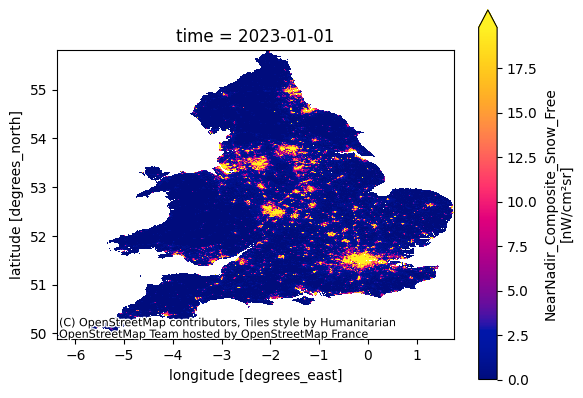

In [14]:
# exploratory visualisation
fig, ax = plt.subplots()

r_2023["NearNadir_Composite_Snow_Free"].sel(time="2023-01-01").plot.pcolormesh(
    ax=ax,
    cmap=cc.cm.bmy,
    robust=True,
)
cx.add_basemap(ax, crs=msoa.crs.to_string())

plt.show()

In [177]:
r_2023.imag

<xarray.Dataset> Size: 22MB
Dimensions:                        (x: 1954, y: 1423, time: 1)
Coordinates:
  * x                              (x) float64 16kB -6.374 -6.37 ... 1.756 1.76
  * y                              (y) float64 11kB 55.81 55.8 ... 49.89 49.89
  * time                           (time) datetime64[ns] 8B 2023-01-01
Data variables:
    NearNadir_Composite_Snow_Free  (time, y, x) float64 22MB 0.0 0.0 ... 0.0 0.0
Attributes: (12/51)
    AlgorithmType:                     b'SCI'
    AlgorithmVersion:                  b'NPP_PR46A3 2.0.0'
    AREA_OR_POINT:                     Area
    Conventions:                       b'CF-1.6'
    creator_email:                     b'modis-ops@lists.nasa.gov'
    creator_name:                      b'VIIRS Land SIPS Processing Group'
    ...                                ...
    TileID:                            b'61018003'
    VersionID:                         b'001'
    VerticalTileNumber:                b'03'
    WestBoundingCoord:                 0.0
    scale_factor:                      1.0
    add_offset:                        0.0

## 4. Stacking the Data From the Satellite Image
We only subset 4 different bands since the K-means neighbourhood method of clustering does not preform well when the input dimension is high.

**Note that the black marble satellite image was not included due to the inoperability of the raster object with ee.Image**

In [27]:
# add the ndvi to the image
compiled = median.addBands(ndvi_median)

# subset to relevent bans
bands = ["SR_B4_median","SR_B3_median","SR_B2_median","NDVI_median"]
compiled = compiled.select(bands)

In [28]:
# visualise the compiled data
Map = gmap.Map()

point = ee.Geometry.Rectangle([0, 52, 0, 53])

vis_params = {
    'min': 0,
    'max': 0.3,
    'bands': ['SR_B4_median', 'SR_B3_median', 'SR_B2_median']
}

Map.centerObject(point, 8)
Map.addLayer(compiled, vis_params, "Landsat-9")


## 5. Training on K Mean Clustering to Identify Built Up Area

To employ the K mean clustering throguh the Google Earth Pipeline, we will have to create a few traning points, which we will execute in the image panel created through the cell chunk below.
The pipieline in this section draw references to an article on Medium: https://medium.com/@thukupeter487/machine-learning-with-gee-on-jupyter-notebook-lulc-7148c850a1b9
### 5.1 Training the K-Mean Clustering Transformer

In [ ]:
# instantiate the image_props with the compiled raster
Imageprops = gmap.image_props(compiled)
Map

In [30]:
# vertify that the input for training data is registered
region1 = Map.user_roi
training = compiled.sample(**{
    'region' : region1,
    'scale' : 30,
    'numPixels':5000,
    'seed':0,
    'geometries':True
})

# Map.addLayer(training,{},'training',False)


In [31]:
# specify the transfomer
n_clusters = 7
clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training)

In [ ]:
# Cluster the input using the trained clusterer.
result = compiled.cluster(clusterer)

### 5.2 Inspecting the Result

In [ ]:
#define legend
legend_keys = ['aa','bb','cc','dd','ee','ff','gg']
legend_colors = ['#8DD3C7', '#FFFFB3', '#BEBADA', '#FB8072', '#80B1D3',"#F85A40", "#009854"]
#reclassify the map

# suspect [ , water,,industrial land, residential, asphalt, greenspace]

result = result.remap([0,1,2,3,4,5,6],[1,2,3,4,5,6,7])
Map.addLayer(result,{'min':1,'max':7,'palette':legend_colors},'Labelled clusters')
Map.add_legend(legend_keys =legend_keys,legend_colors=legend_colors,position='topleft')
Map

With the 7 clusters created through the K-means algorithm, we reclassify them into built-up environment and non-built-up environment. The code below help us reclassify the clusters into the built-up clusters (and the converse) and visualise the data for validation.

In [34]:
# verify if the manual allocation fits with expectation
legend_colors = ['#8DD3C7',"#F85A40"]
# legend_keys

binned_result = result.remap([1,2,3,4,5,6,7],[ 1,0,0,0, 1,0,0])
Map.addLayer(binned_result,{'min':0,'max':1,'palette':legend_colors},'Labelled clusters')
# Map.add_legend(legend_keys =legend_keys,legend_colors=legend_colors,position='topleft')
Map

Map(bottom=174546.0, center=[51.54718906424884, -0.0556182861328125], controls=(WidgetControl(options=['positi…

## 6. Return shapefile of residential area
Note that with the MSOA file stored in the repository, the shapefile is in the British National Grid projection. We will need to first reproject the shapefile into EPSG:4326 to be consistent with the satellite image we are working with.

In [35]:
# load msoa 
msoa = gpd.read_file("./data/MOSA_2021")
# inspect the frame
msoa.head()

,MSOA21CD,MSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,E02000001,City of London 001,532384,181355,-0.093490,51.5156,283e7adc-faef-4736-9a0b-146cb27c72ec,"POLYGON ((532153.703 182165.155, 532158.250 18..."
1,E02000002,Barking and Dagenham 001,548267,189685,0.138756,51.5865,7b32290e-3b18-45b1-b5d5-bf778f71e3ce,"POLYGON ((548881.304 190819.980, 548881.125 19..."
2,E02000003,Barking and Dagenham 002,548259,188520,0.138149,51.5760,56f43674-2eda-47c0-819a-0cabeb9595f5,"POLYGON ((548958.555 189072.176, 548954.517 18..."
3,E02000004,Barking and Dagenham 003,551004,186412,0.176828,51.5564,fbedb5c5-b92a-475f-899e-1baf1dbae111,"POLYGON ((551550.056 187364.705, 551528.633 18..."
4,E02000005,Barking and Dagenham 004,548733,186824,0.144267,51.5607,f04829fe-a903-4bca-a88a-ace39fdbd3ac,"POLYGON ((549237.051 187627.941, 549241.319 18..."


In [36]:
# transform the projection
msoa_4326 = msoa.to_crs(epsg = 4326)
# inspect
msoa_4326.head()

,MSOA21CD,MSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,E02000001,City of London 001,532384,181355,-0.093490,51.5156,283e7adc-faef-4736-9a0b-146cb27c72ec,"POLYGON ((-0.09653 51.52295, -0.09647 51.52282..."
1,E02000002,Barking and Dagenham 001,548267,189685,0.138756,51.5865,7b32290e-3b18-45b1-b5d5-bf778f71e3ce,"POLYGON ((0.14807 51.59656, 0.14806 51.59640, ..."
2,E02000003,Barking and Dagenham 002,548259,188520,0.138149,51.5760,56f43674-2eda-47c0-819a-0cabeb9595f5,"POLYGON ((0.14844 51.58083, 0.14838 51.58075, ..."
3,E02000004,Barking and Dagenham 003,551004,186412,0.176828,51.5564,fbedb5c5-b92a-475f-899e-1baf1dbae111,"POLYGON ((0.18508 51.56480, 0.18476 51.56454, ..."
4,E02000005,Barking and Dagenham 004,548733,186824,0.144267,51.5607,f04829fe-a903-4bca-a88a-ace39fdbd3ac,"POLYGON ((0.15185 51.56778, 0.15191 51.56775, ..."


In [ ]:
msoa_scraped = [path[-13:-4] for path in os.listdir("./satellite")]

['E02001867',
 'E02000576',
 'E02000984',
 'E02004512',
 'W02000090',
 'E02003335',
 'E02004328',
 'E02005585',
 'E02006073',
 'E02002215',
 'E02002573',
 'W02000250',
 'E02006072',
 'E02003687',
 'E02001090',
 'E02006502',
 'E02002980',
 'W02000085',
 'E02002604',
 'E02005143',
 'E02003532',
 'E02001325',
 'E02002638',
 'E02001457',
 'E02001899',
 'E02001655',
 'E02001133',
 'E02005425',
 'E02005431',
 'E02002809',
 'E02000039',
 'E02005141',
 'E02005035',
 'E02003322',
 'E02004459',
 'W02000050',
 'E02001079',
 'E02001905',
 'E02004855',
 'E02006515',
 'E02003337',
 'E02002968',
 'E02005975',
 'E02005154',
 'E02000979',
 'E02000789',
 'E02004289',
 'E02004074',
 'E02004060',
 'E02001691',
 'E02000570',
 'E02003045',
 'E02005434',
 'E02001478',
 'E02006465',
 'E02005150',
 'E02004474',
 'W02000280',
 'E02004689',
 'E02001929',
 'W02000242',
 'E02004105',
 'W02000256',
 'E02006706',
 'E02002158',
 'E02007020',
 'E02007008',
 'E02004298',
 'E02001690',
 'E02003939',
 'E02003093',
 'W020

In [54]:
# return a subset of msoa that has not been stored
msoa_scraped = [path[-13:-4] for path in os.listdir("./satellite")]
msoa_sample = msoa_4326[~(msoa_4326["MSOA21CD"].isin(msoa_scraped)) & (msoa_4326["MSOA21CD"].str.contains("E"))].sample(random_state = 42, frac= 0.05)

In [57]:
# Iterate a sampled list of MSOA and return Multi-band GeoTIFF file.
for id, msoa in msoa_sample.iterrows():
  try:
    # return region boundary 
    region = ee.Geometry.BBox(*msoa.geometry.bounds)

    url = binned_result.getDownloadUrl({
        'bands': ['remapped'],
        'region': region,
        'scale': 20,
        'format': 'GEO_TIFF'
    })
    response = requests.get(url)
    id = msoa['MSOA21CD']
    with open(f'img_residential_{id}.tif', 'wb') as fd:
      fd.write(response.content)

  except Exception as error:
    # handle the exception
    print(f"An exception occurred when loading {id}: {type(error).__name__}")


KeyboardInterrupt: 

We will move all output .tif into the satellite image folder.

In [3]:
file_names = [file for file in os.listdir() if file.endswith('.tif')]
# extract the msoa
msoa_scrapped = [file.split(".")[-2][-9:] for file in file_names]



In [4]:
# move the files to a folder
source_dir = './'
target_dir = './satellite'

file_names = [file for file in  os.listdir(source_dir) if file.endswith(".tif")]

for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)